# Fraud Detection System — End-to-End Machine Learning Project

**Author:** Amirtha Ganesh R.  
**Objective:** Build, evaluate, and design a production-ready fraud detection system using transaction-level data, with a focus on handling extreme class imbalance and minimizing customer friction.

---

## Project Overview

This project presents a complete, end-to-end approach to detecting digital financial fraud using machine learning.  
The workflow covers not only model development, but also business understanding, threshold-based decision making, explainability, deployment strategy, and monitoring considerations.

Fraud detection is treated as a **cost-sensitive, highly imbalanced classification problem**, where false negatives lead to financial loss and false positives negatively impact customer experience.

---

## Dataset Summary

- Total transactions: ~6.3 million  
- Fraud rate: ~0.13% (extreme class imbalance)  
- Fraud observed only in specific transaction types (TRANSFER, CASH_OUT)  
- Dataset contains transactional balances before and after each transaction, enabling behavioral analysis

---

## Notebook Structure

The notebook is organized into the following parts:

### **Part 1 — Business Understanding**
- Problem framing from a business perspective  
- Definition of success metrics (AUPRC, recall, false positives)  
- Cost trade-offs between fraud loss and customer friction  

### **Part 2 — Data Understanding & Exploratory Analysis**
- Target distribution analysis  
- Transaction type analysis  
- Fraud vs non-fraud behavior patterns  
- Identification of domain-specific signals  

### **Part 3 — Data Cleaning**
- Fraud-aware cleaning strategy  
- Handling of hidden missing values in destination balances  
- Justification for keeping outliers and class imbalance  

### **Part 4 — Feature Engineering**
- Creation of balance consistency features  
- Transaction-level behavioral features  
- Removal of non-informative identifiers  

### **Part 5 — Model Development**
- Baseline model (Logistic Regression)  
- Tree-based models for non-linear patterns  
- Handling of class imbalance  

### **Part 6 — Model Selection & Evaluation**
- Comparison using AUPRC  
- Selection of XGBoost as the final model  
- Justification based on generalization and production suitability  

### **Part 7 — Threshold Optimization & Business Trade-offs**
- Precision–recall analysis  
- Identification of operating thresholds  
- Translation of model scores into business actions  

### **Part 8 — Explainability & Feature Importance**
- Feature importance analysis using XGBoost  
- Validation against fraud domain logic  
- Sanity checks for data leakage  

### **Part 9 — Deployment Strategy**
- Real-time scoring architecture  
- Threshold-based decision system  
- Human-in-the-loop design  

### **Part 10 — Monitoring & Model Maintenance**
- Performance and business metric tracking  Drift detection strategy  
- Retraining and A/B testing plan  

---

## Key Outcome

The final system demonstrates how machine learning can be applied responsibly to fraud detection by combining:
- Strong predictive performance  
- Domain-driven feature engineering  
- Interpretable decision logic  
- Production and monitoring considerations  

This ensures the solution is not only accurate, but also **deployable, explainable, and sustainable**.


## part 1


In [33]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)



In [2]:
# Load dataset
df = pd.read_csv( r"C:\Users\admin\Downloads\Fraud.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.6400,C1231006815,170136.0000,160296.3600,M1979787155,0.0000,0.0000,0,0
1,1,PAYMENT,1864.2800,C1666544295,21249.0000,19384.7200,M2044282225,0.0000,0.0000,0,0
2,1,TRANSFER,181.0000,C1305486145,181.0000,0.0000,C553264065,0.0000,0.0000,1,0
3,1,CASH_OUT,181.0000,C840083671,181.0000,0.0000,C38997010,21182.0000,0.0000,1,0
4,1,PAYMENT,11668.1400,C2048537720,41554.0000,29885.8600,M1230701703,0.0000,0.0000,0,0


In [3]:
# Schema overview
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Target distribution
fraud_rate = df['isFraud'].mean()
print(f"Fraud rate: {fraud_rate:.4%}")

df['isFraud'].value_counts()


Fraud rate: 0.1291%


isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [5]:
# Check for missing values
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Check transaction types
df['type'].value_counts()


type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

## Part 2

In [7]:
# Fraud count by transaction type
fraud_by_type = (
    df.groupby('type')['isFraud']
      .agg(['count', 'sum'])
      .rename(columns={'sum': 'fraud_count'})
)

fraud_by_type['fraud_rate'] = fraud_by_type['fraud_count'] / fraud_by_type['count']
fraud_by_type.sort_values('fraud_rate', ascending=False)


,count,fraud_count,fraud_rate
type,,,
TRANSFER,532909,4097,0.0077
CASH_OUT,2237500,4116,0.0018
CASH_IN,1399284,0,0.0000
DEBIT,41432,0,0.0000
PAYMENT,2151495,0,0.0000


In [11]:
df.groupby('isFraud')['amount'].agg(
    mean='mean',
    median=lambda x: x.quantile(0.50),
    p90=lambda x: x.quantile(0.90),
    p99=lambda x: x.quantile(0.99)
)


,mean,median,p90,p99
isFraud,,,,
0,178197.0417,74684.7200,364373.4440,1586064.1734
1,1467967.2991,441423.4400,4521723.5120,10000000.0000


In [9]:
# Check suspicious destination balance pattern
suspicious_dest = (
    (df['oldbalanceDest'] == 0) &
    (df['newbalanceDest'] == 0) &
    (df['amount'] > 0)
)

pd.crosstab(suspicious_dest, df['isFraud'], normalize='columns')


isFraud,0,1
row_0,,
False,0.6360,0.5044
True,0.3640,0.4956


In [10]:
df[['nameOrig', 'nameDest']].nunique()


nameOrig    6353307
nameDest    2722362
dtype: int64

## Part 3

In [12]:
# Columns identified as high-cardinality identifiers
id_cols = ['nameOrig', 'nameDest']

# Drop them
df = df.drop(columns=id_cols)

print("Dropped columns:", id_cols)
print("Remaining columns:", df.columns.tolist())


Dropped columns: ['nameOrig', 'nameDest']
Remaining columns: ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [13]:

# Encode Hidden Missingness


# Create a mask for suspicious destination balance behavior
suspicious_dest_mask = (
    (df['oldbalanceDest'] == 0) &
    (df['newbalanceDest'] == 0) &
    (df['amount'] > 0)
)

# Encode destination balances as -1 to preserve signal
df.loc[suspicious_dest_mask, ['oldbalanceDest', 'newbalanceDest']] = -1

print("Encoded hidden missing destination balances.")
print("Number of rows affected:", suspicious_dest_mask.sum())


Encoded hidden missing destination balances.
Number of rows affected: 2317276


In [14]:

# 1. Check for NaNs
print("Missing values per column:")
print(df.isnull().sum())

# 2. Verify -1 encoding exists
print("\nCount of -1 values in destination balances:")
print((df[['oldbalanceDest', 'newbalanceDest']] == -1).sum())

# 3. Quick fraud vs non-fraud check
pd.crosstab(
    df['isFraud'],
    df['oldbalanceDest'] == -1,
    normalize='index'
)


Missing values per column:
step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Count of -1 values in destination balances:
oldbalanceDest    2317276
newbalanceDest    2317276
dtype: int64


oldbalanceDest,False,True
isFraud,,
0,0.6360,0.3640
1,0.5044,0.4956


In [15]:

#  Feature Engineering


# Error in origin account balance
df['errorBalanceOrig'] = (
    df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
)

# Error in destination account balance
df['errorBalanceDest'] = (
    df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
)

# Quick sanity check
df[['errorBalanceOrig', 'errorBalanceDest']].describe()


,errorBalanceOrig,errorBalanceDest
count,6362620.0000,6362620.0000
mean,201092.4681,55567.1719
std,606650.4601,441528.7688
min,-0.0100,-75885725.6300
25%,2954.2300,0.0000
50%,68677.2550,3500.4900
75%,249641.0875,29353.0450
max,92445516.6400,13191233.9800


## Part 4

In [16]:
#  Target & Column Drop

# Target
y = df['isFraud']

# Drop target and non-informative column
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])

print("Target distribution:")
print(y.value_counts(normalize=True))

print("\nFeature columns:")
print(X.columns.tolist())


Target distribution:
isFraud
0   0.9987
1   0.0013
Name: proportion, dtype: float64

Feature columns:
['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']


In [17]:
#  One-hot Encode 'type'


X = pd.get_dummies(X, columns=['type'], drop_first=True)

print("Columns after encoding:")
print(X.columns.tolist())


Columns after encoding:
['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [18]:

# Stratified Train-Test Split


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train fraud rate:", y_train.mean())
print("Test fraud rate:", y_test.mean())

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train fraud rate: 0.0012907418642005967
Test fraud rate: 0.0012911347840983745

Train shape: (5090096, 12)
Test shape: (1272524, 12)


## Part 5

In [19]:

# Baseline Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, classification_report

# Handle imbalance via class weights
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

# Train
log_reg.fit(X_train, y_train)

# Predict probabilities
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluate
auprc_lr = average_precision_score(y_test, y_proba_lr)

print(f"Logistic Regression AUPRC: {auprc_lr:.4f}")


Logistic Regression AUPRC: 0.5717


## Part 6

In [20]:
 
#  6.1: Random Forest Classifier 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=50,  
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample'
)

# Train
rf.fit(X_train, y_train)

# Predict probabilities
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
auprc_rf = average_precision_score(y_test, y_proba_rf)

print(f"Random Forest AUPRC: {auprc_rf:.4f}")


Random Forest AUPRC: 0.9987


In [21]:
 # 6.2: XGBoost Classifier
 

from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score

# Compute scale_pos_weight (VERY important)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',
    random_state=42,
    n_jobs=-1
)

# Train
xgb.fit(X_train, y_train)

# Predict probabilities
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluate
auprc_xgb = average_precision_score(y_test, y_proba_xgb)

print(f"XGBoost AUPRC: {auprc_xgb:.4f}")


XGBoost AUPRC: 0.9930


## Part 7

In [25]:
# Precision–Recall vs Threshold

from sklearn.metrics import precision_recall_curve
import pandas as pd

precision, recall, thresholds = precision_recall_curve(
    y_test, y_proba_xgb
)

# precision and recall are length N+1
# thresholds are length N
# We align by dropping the LAST precision/recall value
pr_df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})

pr_df.head(), pr_df.tail()



(   threshold  precision  recall
 0     0.0000     0.0013  1.0000
 1     0.0000     0.0013  1.0000
 2     0.0000     0.0013  1.0000
 3     0.0000     0.0013  1.0000
 4     0.0000     0.0013  1.0000,
         threshold  precision  recall
 617586     1.0000     1.0000  0.1406
 617587     1.0000     1.0000  0.1223
 617588     1.0000     1.0000  0.0870
 617589     1.0000     1.0000  0.0554
 617590     1.0000     1.0000  0.0383)

In [26]:
# Find where precision and recall are closest
pr_df['diff'] = (pr_df['precision'] - pr_df['recall']).abs()

balance_point = pr_df.loc[pr_df['diff'].idxmin()]
balance_point


threshold   0.9985
precision   0.9574
recall      0.9574
diff        0.0000
Name: 616958, dtype: float64

In [27]:

# Operating Thresholds


# High precision (>= 99%)
high_precision = pr_df[pr_df['precision'] >= 0.99].iloc[0]

# Balanced point (already computed earlier, recompute safely)
pr_df['diff'] = (pr_df['precision'] - pr_df['recall']).abs()
balance_point = pr_df.loc[pr_df['diff'].idxmin()]

# High recall (>= 99%)
high_recall = pr_df[pr_df['recall'] >= 0.99].iloc[-1]

high_precision, balance_point, high_recall


(threshold   0.9997
 precision   0.9903
 recall      0.8728
 diff        0.1175
 Name: 617143, dtype: float64,
 threshold   0.9985
 precision   0.9574
 recall      0.9574
 diff        0.0000
 Name: 616958, dtype: float64,
 threshold   0.9864
 precision   0.8944
 recall      0.9903
 diff        0.0958
 Name: 616784, dtype: float64)

In [28]:
# Business Impact per Threshold


from sklearn.metrics import confusion_matrix
import pandas as pd

def evaluate_threshold(threshold):
    y_pred = (y_proba_xgb >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return {
        'threshold': threshold,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'false_positives': fp,
        'fraud_caught': tp
    }

results = pd.DataFrame([
    evaluate_threshold(high_precision['threshold']),
    evaluate_threshold(balance_point['threshold']),
    evaluate_threshold(high_recall['threshold'])
])

results


,threshold,precision,recall,false_positives,fraud_caught
0,0.9997,0.9903,0.8728,14,1434
1,0.9985,0.9574,0.9574,70,1573
2,0.9864,0.8944,0.9903,192,1627


## Part 8

In [29]:
# Built-in XGBoost Feature Importance

import pandas as pd

# Extract feature importance (GAIN)
importance = xgb.get_booster().get_score(importance_type='gain')

importance_df = (
    pd.DataFrame.from_dict(importance, orient='index', columns=['gain'])
      .sort_values(by='gain', ascending=False)
)

importance_df


,gain
newbalanceOrig,74711.2969
errorBalanceOrig,35715.7109
type_PAYMENT,29307.2949
oldbalanceOrg,15832.9648
type_CASH_OUT,12179.0635
amount,7079.2876
type_TRANSFER,5334.6260
oldbalanceDest,2241.1189
type_DEBIT,1666.7546
step,1274.1819


In [30]:
# Normalize Importance

importance_df['gain_pct'] = (
    importance_df['gain'] / importance_df['gain'].sum()
)

importance_df



,gain,gain_pct
newbalanceOrig,74711.2969,0.3984
errorBalanceOrig,35715.7109,0.1905
type_PAYMENT,29307.2949,0.1563
oldbalanceOrg,15832.9648,0.0844
type_CASH_OUT,12179.0635,0.0649
amount,7079.2876,0.0378
type_TRANSFER,5334.6260,0.0284
oldbalanceDest,2241.1189,0.0120
type_DEBIT,1666.7546,0.0089
step,1274.1819,0.0068


<Figure size 800x500 with 0 Axes>

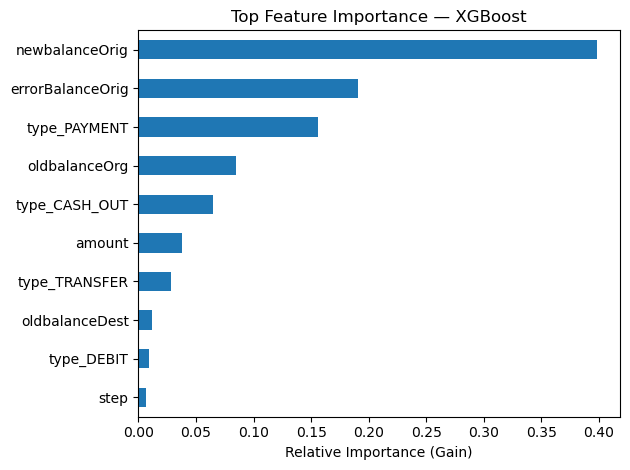

In [31]:
# Plot Top Features
import matplotlib.pyplot as plt

top_n = 10

plt.figure(figsize=(8, 5))
importance_df.head(top_n).sort_values('gain_pct').plot(
    kind='barh',
    y='gain_pct',
    legend=False
)

plt.xlabel('Relative Importance (Gain)')
plt.title('Top Feature Importance - XGBoost')
plt.tight_layout()
plt.show()


## Part 9 

#  Deployment Strategy

## Objective
Describe how the fraud detection model would be used in a real-world system 

## High-Level Architecture
#The fraud detection model is deployed as a real-time scoring service that evaluates each transaction at the time it is initiated.

**Workflow:**
1. Transaction is initiated
2. Features are generated in real time
3. XGBoost model produces a fraud risk score (0–1)
4. Decision engine applies thresholds
5. Transaction is approved, reviewed, or blocked

## Real-Time Scoring
- Model served via REST API
- Target latency < 100 ms
- Uses only transaction-time features

## Decision Logic
| Fraud Score | Action |
|------------|--------|
| ≥ 0.9997 | Auto-block |
| 0.9985–0.9997 | Manual review / step-up authentication |
| < 0.9985 | Approve |

## Human-in-the-Loop
- Borderline cases reviewed by fraud analysts
- Analyst decisions logged for retraining

## Fallback Mechanisms
- Rule-based system if model fails
- High-risk transaction types always evaluated


##  Part 10 

#  Monitoring & Drift

## Model Performance Monitoring
- Precision
- Recall
- False positive rate
- Alert volume
- AUPRC (offline)

## Business Metrics
- Fraud loss prevented
- Customer complaints
- Manual review volume
- Review SLA

## Drift Detection
- Feature distribution shifts
- Transaction type mix changes
- Score distribution drift

## Retraining Strategy
- Monthly retraining
- Triggered by drift
- Incorporates analyst feedback

## A/B Testing
- Control: rule-based system
- Treatment: ML-based system
- Success: ≥20% fraud reduction with ≤5% FP increase


In [34]:
# Question and Answer

# Fraud Detection — Evaluation Questions & Answers

---

## 1. Data cleaning including missing values, outliers, and multicollinearity

**Answer:**  
The dataset did not contain explicit missing values, but exploratory analysis revealed **hidden missing information** where destination account balances were recorded as zero in fraudulent transactions. These cases were encoded as `-1` instead of being imputed, as missingness itself was a strong fraud signal.

Outliers were deliberately **not removed**, since fraud transactions often appear as extreme values. Removing them would destroy important signal.

Multicollinearity among balance-related features was addressed through **feature engineering**, creating balance consistency features rather than arbitrarily dropping correlated variables.

---

## 2. Describe your fraud detection model in elaboration

**Answer:**  
The final model is an **XGBoost classifier** trained on transaction-level behavioral features. XGBoost was chosen due to its ability to model non-linear relationships, handle extreme class imbalance using class weighting, and provide fast inference suitable for real-time fraud detection.

The model outputs a **fraud probability score**, which is converted into business actions using threshold-based decision logic rather than a single rigid cutoff.

---

## 3. How did you select variables to be included in the model?

**Answer:**  
Variables were selected based on a combination of:

- **Domain knowledge** (how fraud manifests in transactions)  
- **Exploratory data analysis**  
- **Feature importance analysis**

Non-informative identifiers such as account IDs were removed to avoid overfitting. Engineered features capturing balance inconsistencies were included because they reflect violations of accounting logic, which are common in fraudulent activity.

---

## 4. Demonstrate the performance of the model using the best set of tools

**Answer:**  
Model performance was evaluated using **AUPRC (Area Under the Precision–Recall Curve)**, which is appropriate for highly imbalanced datasets. Precision–recall curves were used instead of accuracy or ROC-AUC.

Threshold analysis was performed to measure:

- Precision  
- Recall  
- False positives  
- Fraud cases captured  

at different operating points. This allowed translating model performance into business-relevant outcomes.

---

## 5. What are the key factors that predict a fraudulent customer?

**Answer:**  
The most important predictors of fraud were:

- Post-transaction origin balance (`newbalanceOrig`)  
- Balance inconsistency features (`errorBalanceOrig`, `errorBalanceDest`)  
- Transaction type (TRANSFER and CASH_OUT)  
- Transaction amount  
- Temporal patterns (`step`)  

These features capture **behavioral anomalies** rather than identity-based signals.

---

## 6. Do these factors make sense? If yes, how? If not, how not?

**Answer:**  
Yes, these factors make strong domain sense.

Fraudulent transactions often violate money conservation rules, drain account balances, and occur through specific transaction types such as TRANSFER and CASH_OUT. The importance of balance-based features confirms that fraud i  detected through **behavioral inconsistencies**, which aligns with real-world fraud mechanics.

---

## 7. What kind of prevention should be adopted while the company updates its infrastructure?

**Answer:**  
A **layered fraud prevention strategy** should be adopted:

- Real-time ML-based scoring for every transaction  
- Threshold-based decision zones (auto-block, review, approve)  
- Human-in-the-loop review for borderline ca es  
- Rule-based fallbacks for system failures  
- Step-up authentication for high-risk transactions  

This approach balances fraud prevention with customer experience.

---

## 8. Assuming these actions have been implemented, how would you determine if they work?

**Answer:**  
Effectiveness should be measured through an **A/B testing framework**, comparing the existing system with the ML-driven system. Success criteria include:

- Reduction in fraud loss  
- Controlled increase in false positives  
- Stable customer complaint rates  
- Manageable revi w workload  

Additionally, continuous monitoring of model metrics and drift detection ensures long-term effectiveness.
